In [100]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM
from keras.layers import Dropout
import keras.optimizers
from keras.layers import Embedding,Flatten

from keras import layers
from keras.layers import Input,Embedding, Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dense,Dropout,LSTM,Flatten,GRU,Bidirectional,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns             
from keras import regularizers
from keras.models import Model

In [101]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of images used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12


In [102]:
#################
# Configuration #
#################

# dictionary of languages that our classifier will cover
#LANGUAGES_DICT = {'BEI':0,'MSA':1,'CAI':2,'DOH':3,'RAB':4,'TUN':5}

LANGUAGES_DICT = {'ALE':0,'ALG':1,'ALX':2,'AMM':3,'ASW':4,'BAG':5,
                'BAS':6,'BEI':7,'BEN':8,'CAI':9,'DAM':10,'DOH':11,
                  'FES':12,'JED':13,'JER':14,'KHA':15,'MOS':16,'MSA':17,
                  'MUS':18,'RAB':19,'RIY':20,'SAL':21,'SAN':22,'SFX':23,
                  'TRI':24,'TUN':25}


# Length of cleaned text used for training and prediction - 140 chars
MAX_LEN = 100

# number of language samples per language that we will extract from source files
NUM_SAMPLES = 1600
NUM_test = 200

# For reproducibility
SEED = 42

import support #import define_alphabet
# Load the Alphabet
alphabet = support.define_alphabet()
print('ALPHABET:')
print(alphabet[1])

VOCAB_SIZE = len(alphabet[1])
print('ALPHABET LEN(VOCAB SIZE):', VOCAB_SIZE)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "../data/Dialect26"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
source_directory_test = os.path.join(data_directory, 'source_test')
cleaned_directory_test =os.path.join(data_directory, 'cleaned_test')
samples_directory = os.path.join('/tmp', 'samples')
train_test_directory = os.path.join('/tmp', 'train_test')

ALPHABET:
ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي ؟!?¿¡
ALPHABET LEN(VOCAB SIZE): 42


In [103]:
from support import get_sample_text, get_input_row
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "BEI_clean.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*MAX_LEN)
    sample_text = get_sample_text(content,random_index,MAX_LEN)
    print ("1. SAMPLE TEXT: \n", sample_text)
    print ("\n2. REFERENCE ALPHABET: \n", alphabet[0])
    
    sample_input_row = get_input_row(content, random_index, MAX_LEN, alphabet)
    print ("\n3. SAMPLE INPUT ROW: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != VOCAB_SIZE:
        print("Something strange happened!")
        
    print ("\n4. INPUT SIZE (VOCAB SIZE): ", input_size)
    del content

1. SAMPLE TEXT: 
 غير العداد ؟
 بقدر شوف هيدا ؟
 وعدت حالي إنو أول ما شوفك بدي إتعرف عليك
 شو صاير بالفترة الأخيرة ؟


2. REFERENCE ALPHABET: 
 ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', ' ', '؟', '!', '?', '¿', '¡']

3. SAMPLE INPUT ROW: 
 [0, 0, 2, 0, 2, 0, 8, 3, 2, 3, 0, 0, 1, 1, 6, 0, 6, 0, 0, 3, 1, 0, 0, 0, 4, 1, 4, 1, 2, 6, 1, 1, 1, 6, 0, 7, 20, 3, 0, 0, 0, 0]

4. INPUT SIZE (VOCAB SIZE):  42


In [85]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        print(content_length)
        remaining = content_length - MAX_LEN*NUM_SAMPLES
        jump = int(((remaining/NUM_SAMPLES)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_SAMPLES):
            if (content_length-start_index < MAX_LEN+50):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(idx,' ',start_index,' ',MAX_LEN)
            
            sample_data[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1
            #print(counter)
            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
print(counter)
new_data = sample_data[:counter-1,]
np.random.shuffle(new_data)
print(set(new_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",new_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang26_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=new_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data,new_data

Processing file : ../data/Dialect26/cleaned/ALE_clean.txt
47261
File size :  0.05 MB  | # possible samples :  1125 | # skip chars : -52
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALG_clean.txt
52703
File size :  0.05 MB  | # possible samples :  1254 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALX_clean.txt
51316
File size :  0.05 MB  | # possible samples :  1221 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/AMM_clean.txt
51378
File size :  0.05 MB  | # possible samples :  1223 | # skip chars : -50
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ASW_clea

In [104]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        lines = f.readlines()
        content_length = len(''.join(lines))  
        print ("File size : ",size_mb(content_length))
        for file_content in lines:
            TEXT= file_content
            remaining = content_length - MAX_LEN*NUM_test
            jump = int(((remaining/NUM_test)*3)/4)
            
            #for idx in range(NUM_test):
                #if (content_length-start_index < 400):
                    #break
            #print(TEXT)
            while len(TEXT) < MAX_LEN+10:
                TEXT += ' '+TEXT
               
            input_row = get_input_row(TEXT, 0, MAX_LEN, alphabet)
                #print(NUM_test*lang_seq+idx)
            sample_data[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1

            #start_index += MAX_LEN + jump
        del lines
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
print(counter)

np.random.shuffle(sample_data)
print(set(sample_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang26_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data


Processing file : ../data/Dialect26/cleaned/ALE_clean.txt
File size :  0.05 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALG_clean.txt
File size :  0.05 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ALX_clean.txt
File size :  0.05 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/AMM_clean.txt
File size :  0.05 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/ASW_clean.txt
File size :  0.05 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned/BAG_clean.txt
File size :  0.05 MB
---------------------

In [105]:
sample_data_test = np.empty((NUM_test*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
print(len(sample_data_test))
#print(set(sample_data_test[:,-1]))
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory_test,lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        lines = f.readlines()
        content_length = len(''.join(lines))  
        print ("File size : ",size_mb(content_length))
        for file_content in lines:
            TEXT= file_content
            remaining = content_length - MAX_LEN*NUM_test
            jump = int(((remaining/NUM_test)*3)/4)
            
            #for idx in range(NUM_test):
                #if (content_length-start_index < 400):
                    #break
            #print(TEXT)
            while len(TEXT) < MAX_LEN+10:
                TEXT += ' '+TEXT
               
            input_row = get_input_row(TEXT, 0, MAX_LEN, alphabet)
                #print(NUM_test*lang_seq+idx)
            sample_data_test[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1

            #start_index += MAX_LEN + jump
        del lines
    lang_seq += 1
    print (100*"-")
#print('idx',idx)
print('counter',counter)
print(len(sample_data_test[:counter,]))

    
# Let's randomy shuffle the data
#np.random.shuffle(new_data)
print(set(sample_data_test[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data_test.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl_test = os.path.join(samples_directory,"lang26_samples_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl_test,data=sample_data_test)
print(path_smpl_test, "size : ", size_mb(os.path.getsize(path_smpl_test)))
del sample_data_test

5200
Processing file : ../data/Dialect26/cleaned_test/ALE_clean.txt
File size :  0.01 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ALG_clean.txt
File size :  0.01 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ALX_clean.txt
File size :  0.01 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/AMM_clean.txt
File size :  0.01 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/ASW_clean.txt
File size :  0.01 MB
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect26/cleaned_test/BAG_clean.txt
File si

In [106]:
# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in LANGUAGES_DICT.items():
        if did == langid:
            return dname

# Loading the data
path_smpl = os.path.join(samples_directory,"lang26_samples_"+str(VOCAB_SIZE)+".npz")
dt = np.load(path_smpl)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("\nSample language : ",decode_langid(dt[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  0  0  0  0  0 12  0 12  0  0  0 12  0  0  0  0  0 12  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 12 23  0  0  0  0  0  7]

Sample language :  BEI

Dataset shape (Total_samples, Alphabet): (41600, 43)
Language bins count (samples per language): 
ALE 1600
ALG 1600
ALX 1600
AMM 1600
ASW 1600
BAG 1600
BAS 1600
BEI 1600
BEN 1600
CAI 1600
DAM 1600
DOH 1600
FES 1600
JED 1600
JER 1600
KHA 1600
MOS 1600
MSA 1600
MUS 1600
RAB 1600
RIY 1600
SAL 1600
SAN 1600
SFX 1600
TRI 1600
TUN 1600


In [107]:


# Loading the data
path_smpl_test = os.path.join(samples_directory,"lang26_samples_test_"+str(VOCAB_SIZE)+".npz")
dt_test = np.load(path_smpl_test)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt_test.shape[0])
print ("Sample record : \n",dt_test[random_index,])
print ("\nSample language : ",decode_langid(dt_test[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt_test.shape)
bins_test = np.bincount(dt_test[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins_test[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  0  5  0  0  0 15  5  5  5  0  5  0  0  0  0  5  0  0  0  0  5  0  0
  0  5  0  0  5  0  0  0  0  0  0 15 19  0  0  0  0  0 18]

Sample language :  MUS

Dataset shape (Total_samples, Alphabet): (5200, 43)
Language bins count (samples per language): 
ALE 200
ALG 200
ALX 200
AMM 200
ASW 200
BAG 200
BAS 200
BEI 200
BEN 200
CAI 200
DAM 200
DOH 200
FES 200
JED 200
JER 200
KHA 200
MOS 200
MSA 200
MUS 200
RAB 200
RIY 200
SAL 200
SAN 200
SFX 200
TRI 200
TUN 200


In [108]:
# we need to preprocess data for DNN yet again - scale it 
# scaling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float32)
dt_test = dt_test.astype(np.float32)
# X and Y split
X_train = dt[:, 0:input_size] # Samples
Y_train = dt[:, input_size] # The last element is the label
print(set(Y_train))
X_test = dt_test[:, 0:input_size] # Samples
Y_test = dt_test[:, input_size] # The last element is the label
print(set(Y_test))
del dt,dt_test

# Random index to check random sample
random_index_train = random.randrange(0,X_train.shape[0])
print("Example data before processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])


# Random index to check random sample
random_index_test = random.randrange(0,X_test.shape[0])
print("Example data before processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# X PREPROCESSING
# Feature Standardization - Standar scaler will be useful later during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X = standard_scaler.transform(X_train)   
print ("X preprocessed shape :", X_train.shape)

standard_scaler = preprocessing.StandardScaler().fit(X_test)
X = standard_scaler.transform(X_test)   
print ("X preprocessed shape :", X_test.shape)


# Y PREPROCESSINGY 
# One-hot encoding
Y_train = keras.utils.to_categorical(Y_train, num_classes=len(LANGUAGES_DICT))
Y_test = keras.utils.to_categorical(Y_test, num_classes=len(LANGUAGES_DICT))


# See the sample data
print("\nExample data after processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])

print("\nExample  tets data after processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# Train/test split. Static seed to have comparable results for different runs
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)


# Create the train / test directory if not extists
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Save compressed train_test data to disk
path_tt = os.path.join(train_test_directory,"train26_test_data_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))


path_tt_test = os.path.join(train_test_directory,"train26_test_data_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt_test,X_test=X_test,Y_test=Y_test)
print(path_tt_test, "size : ",size_mb(os.path.getsize(path_tt_test)))


del X_train,Y_train,X_test,Y_test


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0}
Example data before processing:
X : 
 [ 0.  0.  3.  0.  3.  0. 12.  5.  0. 18.  0.  3.  0.  0.  0.  0.  5.  0.
  6.  0.  0.  2.  0.  0.  3.  0.  0.  3.  0.  6.  0.  3.  2.  0.  0.  6.
 15.  0.  0.  0.  0.  0.]
Y : 
 4.0
Example data before processing:
X : 
 [ 0.  0.  0.  0.  0.  0.  7.  0.  0.  6.  0.  0.  3.  0.  3.  0.  3.  0.
  3.  0.  0.  0.  0.  0.  7.  0.  4.  0.  7.  4.  6. 10.  0.  4.  0.  3.
 22.  3.  0.  0.  0.  0.]
Y : 
 24.0
X preprocessed shape : (41600, 42)
X preprocessed shape : (5200, 42)

Example data after processing:
X : 
 [ 0.  0.  3.  0.  3.  0. 12.  5.  0. 18.  0.  3.  0.  0.  0.  0.  5.  0.
  6.  0.  0.  2.  0.  0.  3.  0.  0.  3.  0.  6.  0.  3.  2.  0.  0.  6.
 15.  0.  0.

In [109]:

# Load train data first from file
path_tt = os.path.join(train_test_directory, "train26_test_data_"+str(VOCAB_SIZE)+".npz")
train_test_data = np.load(path_tt)
# Load train data first from file
path_tt_test = os.path.join(train_test_directory, "train26_test_data_test_"+str(VOCAB_SIZE)+".npz")
train_test_data_test = np.load(path_tt_test)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data_test['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data_test['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (41600, 42)
Y_train:  (41600, 26)
X_test:  (5200, 42)
Y_test:  (5200, 26)


In [91]:
model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.
model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(200, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="sigmoid"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 500)               21500     
_________________________________________________________________
dropout_19 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_20 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 26)                5226      
Total para

In [114]:
model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.
model.add(Embedding(4000, 150,trainable=True, input_length=42)) 
model.add(Dense(200, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="sigmoid"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 42, 150)           600000    
_________________________________________________________________
dense_66 (Dense)             (None, 42, 200)           30200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 42, 200)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8400)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 26)                218426    
Total params: 848,626
Trainable params: 848,626
Non-trainable params: 0
_________________________________________________________________


In [115]:
from keras.callbacks import TensorBoard

# Tensorboard
tensorboard = TensorBoard(log_dir="run")
from keras.callbacks import EarlyStopping,ModelCheckpoint
#model.load_weights(filepath)
#filepath="weights.best.madar26_503.hdf5" acc: 69.92%
#filepath="weights.best.madar26_500.hdf5" is the best 69.33
#filepath="weights.best.madar26_501.hdf5" acc: 69.81%

filepath="weights.best.madar26_1layer.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint]

# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
                  epochs=1000,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=callbacks_list,#[tensorboard],
                  shuffle=True#,
                  #verbose=2
                   )


model.save_weights(filepath) 

Train on 37440 samples, validate on 4160 samples
Epoch 1/1000
37440/37440 [==============================] - 21s 563us/step - loss: 3.2614 - acc: 0.0385 - val_loss: 3.2581 - val_acc: 0.0387

Epoch 00001: val_loss improved from inf to 3.25809, saving model to weights.best.madar26_1layer.hdf5
Epoch 2/1000
37440/37440 [==============================] - 20s 540us/step - loss: 3.2581 - acc: 0.0384 - val_loss: 3.2581 - val_acc: 0.0387

Epoch 00002: val_loss did not improve from 3.25809
Epoch 3/1000
37440/37440 [==============================] - 20s 521us/step - loss: 3.2581 - acc: 0.0384 - val_loss: 3.2581 - val_acc: 0.0387

Epoch 00003: val_loss did not improve from 3.25809
Epoch 4/1000
37440/37440 [==============================] - 21s 555us/step - loss: 3.2581 - acc: 0.0384 - val_loss: 3.2581 - val_acc: 0.0387

Epoch 00004: val_loss did not improve from 3.25809
Epoch 5/1000
 7424/37440 [====>.........................] - ETA: 17s - loss: 3.2581 - acc: 0.0379

KeyboardInterrupt: 

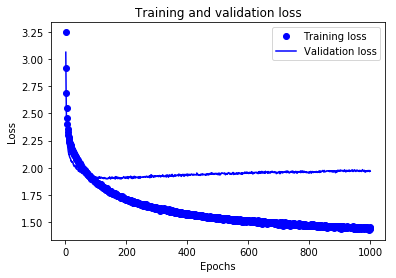

In [97]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



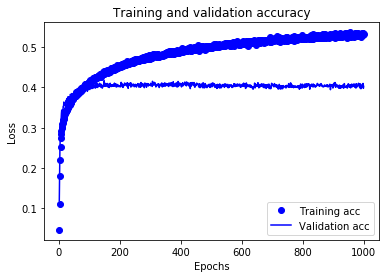

In [98]:
history_dict = history.history
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [99]:
#filepath="weights.best.madar26_503.hdf5" 
model.load_weights(filepath)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5200/5200 [==============================] - 0s 74us/step
acc: 15.19%


              precision    recall  f1-score   support

           0       0.41      0.12      0.19       200
           1       0.17      0.06      0.08       200
           2       0.58      0.26      0.35       200
           3       0.09      0.04      0.06       200
           4       0.23      0.10      0.14       200
           5       0.15      0.08      0.10       200
           6       0.26      0.09      0.13       200
           7       0.26      0.18      0.22       200
           8       0.21      0.10      0.13       200
           9       0.13      0.09      0.11       200
          10       0.10      0.04      0.06       200
          11       0.13      0.10      0.11       200
          12       0.32      0.11      0.16       200
          13       0.06      0.49      0.10       200
          14       0.17      0.11      0.13       200
          15       0.13      0.26      0.17       200
          16       0.34      0.20      0.25       200
          17       0.43    

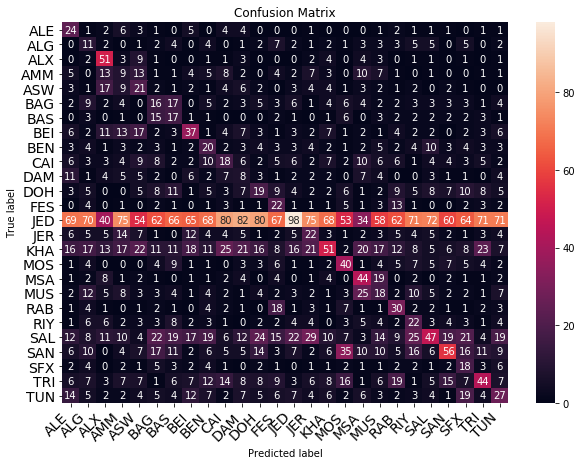

In [96]:
# and now we will prepare data for scikit-learn confusion matrix and classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LANGUAGES_DICT))
LABELS =  list(LANGUAGES_DICT.keys())
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix,classification_report
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = print_confusion_matrix(cnf_matrix, LABELS)
print(classification_report(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1)))


In [ ]:
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT,lang_code):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    print(" it is {}/{}".format(len(TEXT), MAX_LEN))
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    #print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)
    print('\nPREDICTION:', prediction.upper(), '  Actual',lang_code, '\t SCORE:', score)
    
    return score



#test_file = cleaned_directory_test
        
    
#interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'));




for lang_code in ['BEI']:#LANGUAGES_DICT:
    Acc = 0
    start_index = 0
    path = os.path.join(cleaned_directory_test,lang_code+"_clean.txt")
    with open(path, 'r') as f:
            print ("Processing file : " + path)
            lines = f.readlines()
            content_length = len(''.join(lines))  
            print ("File size : ",size_mb(content_length))
            for file_content in lines:
                TEXT= file_content
                remaining = content_length - MAX_LEN*NUM_test
                jump = int(((remaining/NUM_test)*3)/4)

                #for idx in range(NUM_test):
                    #if (content_length-start_index < 400):
                        #break
                
                print(TEXT)
                while len(TEXT) < MAX_LEN+50:
                    TEXT += ' '+TEXT
                
                Acc += get_prediction(TEXT,lang_code)
                
            print('Final Accuracy =', (Acc/len(lines)))




In [ ]:
6497